In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append('/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/')
from exp_hp import get_hp
from utils import balance_classes

2024-01-05 17:48:08.209128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 17:48:08.496554: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


### Load standardized OBS

In [2]:
# EXP_NAME = 'exp1.1' #'exp1.1'#'exp1.2.1' --> doesn't matter which one, just getting the lead and location
# hps = get_hp(EXP_NAME)
# months = [11,12,1,2] # months for X (Y+leadtime are accounted for in function)
# lead = hps['LEAD']
# latpt = hps['region'][0]  # 45 or 55
# lonpt = hps['region'][1]

cesmstd = True
EXP_NAME = 'exp3'
hps = get_hp(EXP_NAME)
months = [11,12,1,2] # months for X (Y+leadtime are accounted for in function)
lead = hps['LEAD']
valmem = hps['val_mems'][0] 
testmem = hps['test_mems'][0]
latpt = hps['region'][0]  
lonpt = hps['region'][1]

In [3]:
%%time
precip_obs_path = '/glade/scratch/kjmayer/DATA/GPCP/PRECT/daily/NN_data/'
precip_obs_finame = 'precip_gpcp_7dayrunmean_1997-202209_20S-20N_regrid2.5x2.5_finetunetrain_polydetrendyrs97-22.nc'

z500_obs_path = '/glade/scratch/kjmayer/DATA/ERA5/z500/NN_data/'
z500_obs_finame = 'z500_daily_era5_7daymean_1997-202209_20-90N_regrid2.5x2.5_finetunetrain_polydetrendyrs97-22.nc'

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [6]:
# ------ X LOAD --------
X2xr = xr.open_dataarray(precip_obs_path+precip_obs_finame)
X2xr_NDJF = X2xr[X2xr.time.dt.month.isin(months)]

Y2xr = xr.open_dataarray(z500_obs_path+z500_obs_finame)
# Y2xr = Y2xr.where((Y2xr['latitude'] == latpt) & (Y2xr['longitude'] == lonpt),drop = True).squeeze()
Y2xr = Y2xr.where((Y2xr['latitude'] >= 30) & (Y2xr['latitude'] <= 60) & 
                  (Y2xr['longitude'] >= 170) &(Y2xr['longitude'] <= 240),drop = True).mean(['latitude','longitude'])

Y2_leadtime   = pd.to_datetime(X2xr_NDJF.time) + dt.timedelta(days = lead)
Y2xr_leadtime = xr.DataArray(np.array(Y2_leadtime),dims='time',coords={'time':np.array(Y2_leadtime)})
Y2xr_NDJFM    = Y2xr.where(Y2xr['time'] == Y2xr_leadtime,drop = True).squeeze()

if not cesmstd:
    X2xr_mean = X2xr_NDJF.mean('time')
    X2xr_std  = X2xr_NDJF.std('time')
    Y2xr_med = Y2xr_NDJFM.quantile(q=0.5,dim='time',keep_attrs=True)
        
elif cesmstd:
    precip_cesm_path = '/glade/derecho/scratch/kjmayer/DATA/CESM2-LE/HIST/precip/NN_data/'
    z500_cesm_path = '/glade/derecho/scratch/kjmayer/DATA/CESM2-LE/HIST/z500/NN_data/'
    X1train_mean_finame = 'preciptrain_mean_valmem'+str(valmem)+'_testmem'+str(testmem)+'_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrendmems1-20.npy'
    X1train_std_finame = 'preciptrain_std_valmem'+str(valmem)+'_testmem'+str(testmem)+'_7daymean_1950-2014_20S-20N_regrid2.5x2.5_polydetrendmems1-20.npy'
    # Y1train_median_finame = 'z500train_median_valmem'+str(valmem)+'_testmem'+str(testmem)+'_7daymean_1950-2014_regrid2.5x2.5_'+str(latpt)+'Nx'+str(lonpt)+'E_polydetrendmems1-20.npy'
    Y1train_median_finame = 'z500train_median_valmem'+str(valmem)+'_testmem'+str(testmem)+'_7daymean_1950-2014_regrid2.5x2.5_'+str(latpt)+'Nx'+str(lonpt)+'E_polydetrendmems1-20.npy'

    X2xr_mean = np.load(precip_cesm_path+X1train_mean_finame, allow_pickle=True) 
    X2xr_std  = np.load(precip_cesm_path+X1train_std_finame, allow_pickle=True) 
    Y2xr_med  = np.load(z500_cesm_path+Y1train_median_finame, allow_pickle=True)


# ------ standardize -----
X2allxr = (X2xr_NDJF - X2xr_mean)/X2xr_std

Y2allxr = Y2xr_NDJFM - Y2xr_med
Y2allxr[Y2allxr <= 0] = 0
Y2allxr[Y2allxr > 0] = 1

if cesmstd:
    X2allxr, Y2allxr, _ = balance_classes(Xdata=X2allxr, Ydata=Y2allxr)

X2all = X2allxr.values
Y2all = Y2allxr.values

In [7]:
X2all = X2all.reshape((X2all.shape[0],X2all.shape[1]*X2all.shape[2]))

### Test NN

0


2024-01-05 17:49:22.511130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


95/95 [==============================] - 0s 953us/step
1
95/95 [==============================] - 0s 900us/step
2
95/95 [==============================] - 0s 1ms/step
3
95/95 [==============================] - 0s 1ms/step
4
95/95 [==============================] - 0s 918us/step
5
95/95 [==============================] - 0s 912us/step
6
95/95 [==============================] - 0s 908us/step
7
95/95 [==============================] - 0s 915us/step
8
95/95 [==============================] - 0s 906us/step
9
95/95 [==============================] - 0s 908us/step


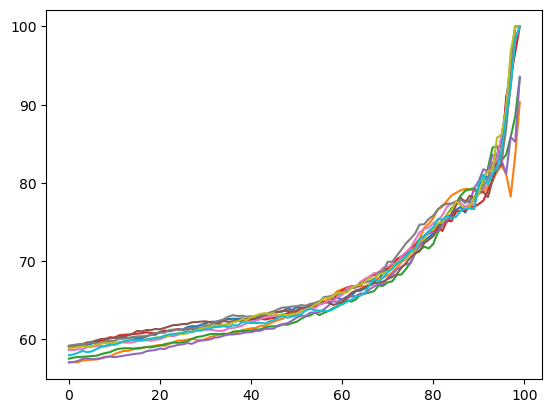

In [8]:
#----- SET UP & TRAIN NN -----
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

acc_all = []
for SEED in range(10):
    print(SEED)
    annfi_name = 'ann1_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann = tf.keras.models.load_model('/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/models/'+annfi_name)
    
    pred = ann.predict(X2all)
    acc = []
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    for q in range(100):
        iconf = np.where(predconf >= np.percentile(predconf,q=q))

        icorr = np.where(predval[iconf] == Y2all[iconf])
        acc.append((len(icorr[0])/len(iconf[0]))*100)
    plt.plot(acc)
    
    acc_all.append(acc)
    
np.save('/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/confvsacc/confvsacc_allobs_ann1'+EXP_NAME+'_cesmstd.npy', acc_all, allow_pickle=True)